## position encoding

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt

$$\text{PE}_{(pos, 2i)}=sin(pos/1000^{2i/d_{model}})$$
$$\text{PE}_{(pos, 2i+1)}=cos(pos/1000^{2i/d_{model}})$$

### 1. angle rate 角速率

The angle rates range from 1 [rads/step] to min_rate [rads/step] over the vector depth.

Formula for angle rate:
$$\text{angle_rate}_d = (\text{min_rate})^{d/d_{max}}$$

In [14]:
num_positions = 50
depth = 512
min_rate = 1/10000

assert depth%2 == 0, "Depth must be even."
angle_rate_exponents = np.linspace(0,1,depth//2)
angle_rates = min_rate**(angle_rate_exponents)

In [15]:
len(angle_rate_exponents)

256

angle_rate 从 1 指数下降到 min_rate.

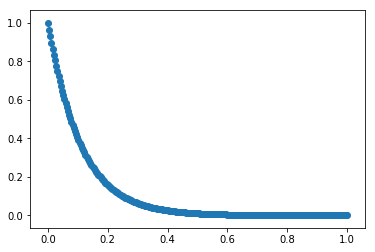

In [17]:
plt.scatter(angle_rate_exponents, angle_rates)

这个图表示的是 ${\text{min_rate}^{2/depth}}^{(i)}$, 其中 i 的范围是 [0, 1,2,3...,256]

Text(0, 0.5, 'Angle rate [rads/step]')

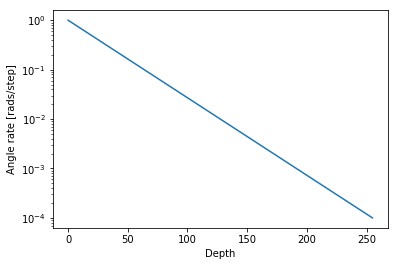

In [16]:
plt.semilogy(angle_rates)  # 半对数图
plt.xlabel('depth')
plt.ylabel('Angle rate [rads/step]')

角速率随着 depth 的增加，指数下降，depth 实际上就是 512 维向量。这里奇数和偶数对应的 angle_rate 是一样的。

### angle_rads

In [7]:
positions = np.arange(num_positions) 
angle_rads = (positions[:, np.newaxis])*angle_rates[np.newaxis, :]
angle_rads.shape

(50, 256)

Broadcasting a multiply over angle rates and positions gives a map of the position encoding angles as a function of depth.  

将 angle_rate 在 position 上进行广播，其目的就是让同一个向量维度的 angle_rad 与 depth 成正比。并且每一个 pos 的 angle_rate 都是指数下降的形式。

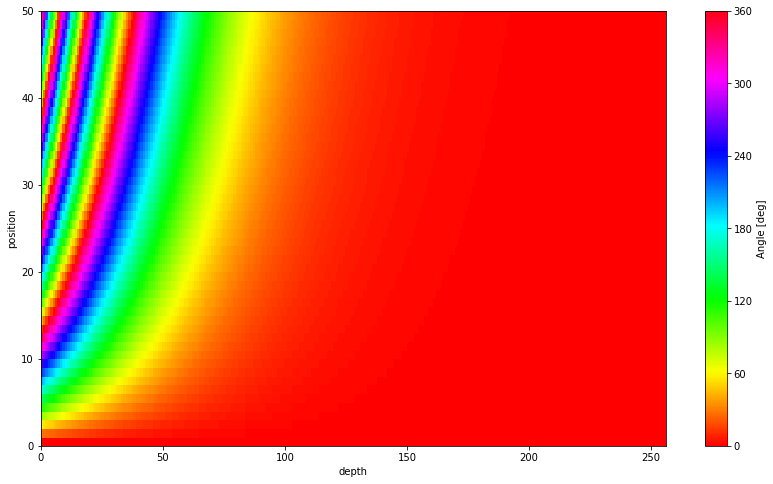

In [20]:
plt.figure(figsize = (14,8))
plt.pcolormesh(
    # Convert to degrees, and wrap around at 360
    angle_rads*180/(2*np.pi) % 360,  # 将角速率转换成 
    # Use a cyclical colormap so that color(0) == color(360)
    cmap='hsv', vmin=0, vmax=360)

plt.xlim([0,len(angle_rates)])
plt.ylabel('position')
plt.xlabel('depth')
bar = plt.colorbar(label='Angle [deg]')
bar.set_ticks(np.linspace(0,360,6+1))

上图表示的是 $\text{pos * angle_rads} = \text{pos} * (\text{min_rate}^{(2*depth)/Depth})$

所以这里的 angle_rad 表示的是 angle 与 pos 和 depth 的关系。  
- 对于同一个 pos，其 angle 随着 depth 指数下降。以 position=50 为例，明显颜色下降很快， 但 position=0 时，angle=0     
- 对于同一个 depth，其 angle 与 position 大小成正比，以 depth=0 为例，angle=pos. 上图中，作者将角速率（弧度）先转换成角度 angle_rads*180/(2*np.pi)，然后对 360 取整。所以 depth=0 为例，其范围变化 
$$[0,50] \rightarrow [0, 50/(2pi)* 180] \rightarrow [0, (pos/(2pi)*180)\%360]$$

### sine and cosine

Raw angles are not a good model input (they're either unbounded, or discontinuous). So take the sine and cosine:

平行角度并不是一个好的模型输入。他们没有边界，也不连续，所以取 sine 和 cosine. 将上面的 angle 转换到 [0,1] 范围内。

In [21]:
sines = np.sin(angle_rads)
cosines = np.cos(angle_rads)
pos_encoding = np.concatenate([sines, cosines], axis=-1) # 直接拼接在一起？

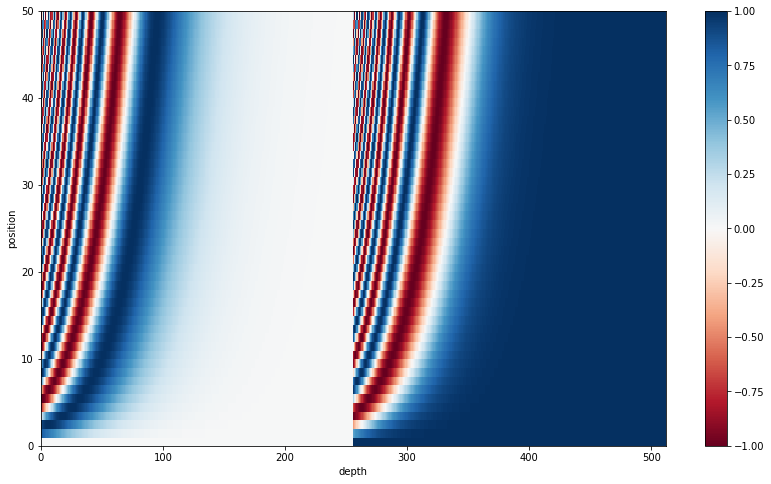

In [26]:
plt.figure(figsize=(14,8))
plt.pcolormesh(pos_encoding, 
               # Use a diverging colormap so it's clear where zero is.
               cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('position')
plt.xlabel('depth')
plt.colorbar()

### Nearby positions

Nearby locations will have similar position-encoding vectors.

相似的位置应该具有相似的 postion-encoding。

这里使用 position=20 来证明这一点。

In [32]:
pos_encoding_at_20 = pos_encoding[20]

dots = np.dot(pos_encoding,pos_encoding_at_20)
delta = np.sum((pos_encoding - pos_encoding_at_20)**2, axis=1)

Text(0.5, 0, 'Position')

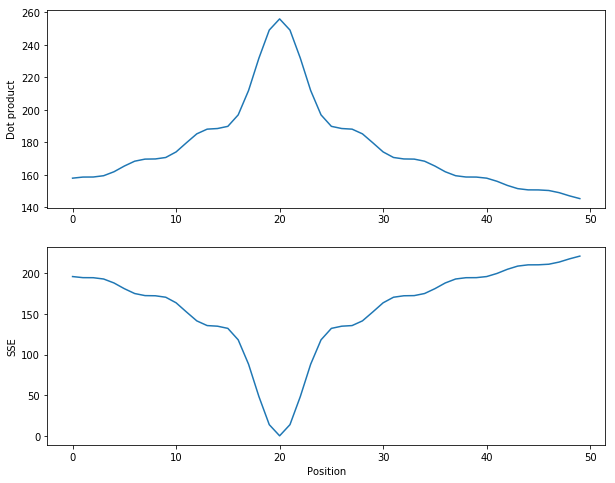

In [33]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylabel('Dot product')
plt.subplot(2,1,2)
plt.plot(delta)
plt.ylabel('SSE')
plt.xlabel('Position')

### Relative positions¶


> where $pos$ is the position and $i$ is the dimension. That is, each dimension of the positional encoding
corresponds to a sinusoid. The wavelengths form a geometric progression from $2π$ to $10000 · 2π$. We
chose this function because we hypothesized it would allow the model to easily learn to attend by
relative positions, since for any fixed offset k, $PE_{pos+k}$ can be represented as a linear function o $PE_{pos}$.  
$PE_{pos}$ 是 $PE_{pos+k}$ 的线性函数。
 
$$PE_{pos+k} = sin[(pos+k) * \text{angle_rate}]=sin(pos*\text{angle_rate} + k*\text{angle_rate})$$
$$PE_{pos+k} = cos[(pos+k) * \text{angle_rate}]=cos(pos*\text{angle_rate} + k*\text{angle_rate})$$

In [47]:
def transition_matrix(position_delta, angle_rates = angle_rates):
    # Implement as a matrix multiply:
    #    sin(a+b) = sin(a)*cos(b)+cos(a)*sin(b)
    #    cos(a+b) = cos(a)*cos(b)-sin(a)*sin(b)
    
    # b
    angle_delta = position_delta*angle_rates   # k* angle_rate
    
    sin_delta = np.sin(angle_delta) # sin(b)
    cos_delta = np.cos(angle_delta) # cos(b)
    
    I = np.eye(len(angle_rates))
    print(I.shape) # (256, 256)
    
    # sin(a+b) = sin(a)*cos(b)+cos(a)*sin(b)
    update_sin = np.concatenate([I*cos_delta, I*sin_delta], axis=0)
    # print(update_sin)
    
    # cos(a+b) = cos(a)*cos(b)-sin(a)*sin(b)
    update_cos = np.concatenate([-I*sin_delta, I*cos_delta], axis=0)
    # print()
    return np.concatenate([update_sin, update_cos], axis=-1)

(256, 256)


Text(0.5, 0, 'depth')

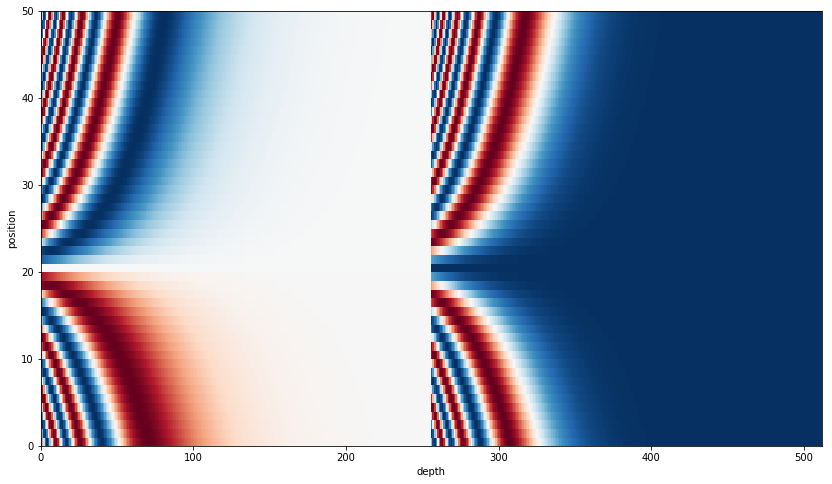

In [58]:
position_delta = -20
update = transition_matrix(position_delta)
plt.figure(figsize=(14,8))
plt.pcolormesh(np.dot(pos_encoding,update), cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('position')
plt.xlabel('depth')

In [59]:
errors = np.dot(pos_encoding,update)[20:] - pos_encoding[:-20]
abs(errors).max()

3.566591466608315e-15

(256, 256)


Text(0.5, 0, 'depth')

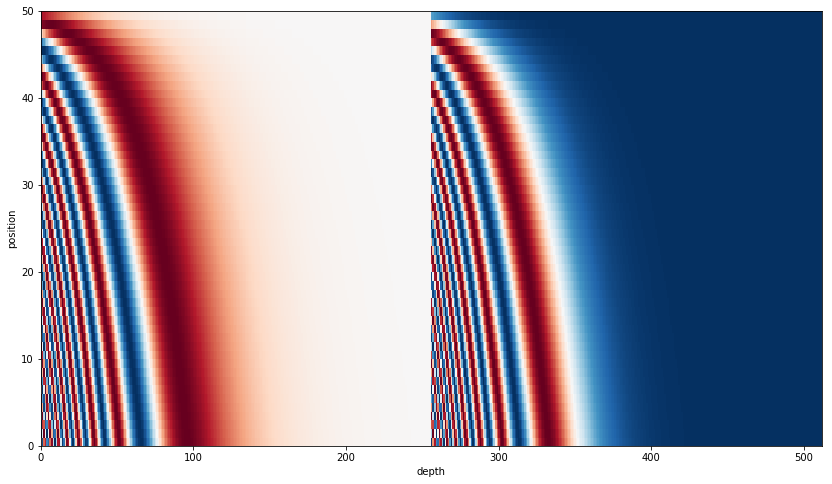

In [60]:
position_delta = -50
update = transition_matrix(position_delta)
plt.figure(figsize=(14,8))
plt.pcolormesh(np.dot(pos_encoding,update), cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('position')
plt.xlabel('depth')

### 总结

position encoding 这样设计的目的是：
1. 同一位置 position 的 angle_rate 是指数下降的，然后 wraps 正弦函数
2. 同一维度 dimension 的 angle_rate 是与 pos 成正比，然后 warps 正弦函数
1. 保证绝对位置相邻的 vector 是相似的  
2. 保证相对位置的 vector 是线性关系。 $PE_{pos_k}=k(PE_{pos})$